In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
#from tensorflow.python.framework.ops import EagerTensor


In [ ]:
def create_content_model(model = None, layer_name = None, layer_index = None):

    content_model = Model(inputs = model.input, outputs = model.get_layer(layer_name).output)
    
    return content_model

In [ ]:
def create_style_model(model = None, layer_names = None):
    outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
    style_model = Model(inputs = model.input, outputs = outputs)
    return style_model

In [ ]:
def content_cost(content_model, content_img, generated_img):
    # Add a preprocess imgs for content and generated here
    #...

    # get the content image & generated img activations
    a_c = content_model(content_img)
    a_g = content_model(generated_img)

    cost = tf.reduce_mean(tf.square(a_c - a_g))

    return cost



In [ ]:
def calculate_gram(activation = None):

    # Get activation dimensions
    _,height, width, channels = activation.shape

    # Unroll the activation/layer output
    a_unrolled = tf.reshape(activation, shape = [height * width, channels])
    gram = tf.matmul(a_unrolled, tf.transpose(a_unrolled))
    #print(gram.shape)
    return gram

In [ ]:
def layer_style_cost(gram_s, gram_g):

    cost = tf.reduce_mean(tf.square(gram_s - gram_g))
    cost = cost / 4
    return cost

In [ ]:
def style_cost(style_activations = None, generated_activations = None, layer_weights = None):

    current_cost = 0
    if layer_weights == None:
        layer_weights = [1. for layer in style_activations]

    for style_activation, generated_activation, weight in zip(style_activations, generated_activations, layer_weights):
        #print(f'{style_activations=}')
        #print(f'{generated_activations=}')
        #print(f'{layer_weights=}')
        gram_g = calculate_gram(generated_activation)
        gram_s = calculate_gram(style_activation)
        #print("gram_g", gram_g.shape)
        #print("gram_s", gram_s.shape)
        current_cost += weight * layer_style_cost(gram_s, gram_g)
    
    cost = current_cost / len(style_activations)
    return cost


In [ ]:
def total_cost(content_cost, style_cost, alpha = .5, beta = .5):
    return alpha * content_cost + beta * style_cost


In [ ]:
#def train_loop(content_img, style_img, style_model = None, content_model = None, epochs = 30 ):
def train_loop(**kwargs ):

    # initializations
    # create content and style models
    content_model = create_content_model(model= model, layer_name = layer_name)
    style_model = create_style_model(model = model, layer_names = layer_names)
    opt = tf.train.AdamOptimizer(learning_rate = 7.)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:

            # keep watch on generated_img
            tape.watch(generated_img)

            # calculate content  cost
            content_cost = content_cost(content_model = content_model, content_img = content_img, generated_img = generated_img)

            # calculate style cost

            style_activations = style_model(style_img)
            generated_activations = style_model(generated_img)
            style_cost = style_cost(style_activations = style_activations, 
                                    generated_activations = generated_activations,
                                    layer_weights = None)

            cost = total_cost(content_cost = content_cost, style_cost = style_cost , alpha = alpha, beta = beta)

        # compute gradients
        grads = tape.gradients(cost, generated_img)
        opt.apply_gradients([(grads, generated_img)])

    return generated_img



In [ ]:
def preprocess(input_img, size=(96, 96, 3), expand_dim=True, switch_bgr_channels=True, normalize=True):
    """
    Preprocesses an input image according to the specified parameters.

    Args:
        input_img (Tensor or ndarray): Input image tensor or ndarray to be preprocessed.
        size (tuple): Desired shape for the preprocessed image tensor.
        expand_dim (bool): If True, expands the dimensions of the image tensor.
        switch_bgr_channels (bool): If True, switches the B and R channels in the image tensor.
        normalize (bool): If True, normalizes the pixel values of the image tensor.

    Returns:
        Tensor: Preprocessed image tensor.
    """
    if isinstance(input_img, np.ndarray):
        # Convert NumPy array to TensorFlow tensor
        #print(input_img.shape)
        input_img = tf.convert_to_tensor(input_img)


    if expand_dim:
        # Expand dimensions if required
        input_img = tf.expand_dims(input_img, axis=0)

    if switch_bgr_channels:
        # Switch B and R channels if required
        input_img = tf.reverse(input_img, axis=[-1])

    if normalize:
        # Normalize pixel values to the range [0, 1]
        input_img = input_img / 255.0

    # Resize the image to the desired shape
    input_img = tf.image.resize(input_img, (size[0], size[1]))

    return input_img



In [ ]:
def deprocess(img_tensor, switch_bgr_channels=True, denormalize=True):
    """
    Deprocesses a preprocessed image tensor according to the specified parameters.

    Args:
        img_tensor (Tensor): Preprocessed image tensor to be deprocessed.
        switch_bgr_channels (bool): If True, switches the B and R channels in the image tensor.
        denormalize (bool): If True, denormalizes the pixel values of the image tensor.

    Returns:
        Tensor or ndarray: Deprocessed image tensor or ndarray.
    """
    if denormalize:
        # Denormalize pixel values to the range [0, 255]
        img_tensor = img_tensor * 255.0

    if switch_bgr_channels:
        # Switch B and R channels if required
        img_tensor = tf.reverse(img_tensor, axis=[-1])

    # Squeeze the tensor to remove the batch dimension
    img_tensor = tf.squeeze(img_tensor, axis=0)

    # Convert TensorFlow tensor to NumPy array
    img_array = img_tensor.numpy()

    return img_array



In [ ]:
def normalize_tensor(tensor):
    # Find the minimum and maximum values of the tensor
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)

    # Normalize the tensor by subtracting the minimum and dividing by the range
    normalized_tensor = (tensor - min_val) / (max_val - min_val)

    return normalized_tensor


In [ ]:
vgg_input_shape = (128, 128, 3)

In [ ]:
model = VGG19(input_shape = vgg_input_shape, include_top= False, weights = 'imagenet')
model.trainable = False


In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
c_m = create_content_model(model = model, layer_name = 'block2_conv2', layer_index = None)
_,height, width, channels = c_m.output_shape
calculate_gram(c_m.output)
print(type(c_m.output))

<class 'keras.engine.keras_tensor.KerasTensor'>


In [ ]:
layer_names = ['block2_conv2', 'block3_conv2', 'block4_conv2']
s_m = create_style_model(model = model, layer_names = layer_names)
print(s_m.output_shape)
print(type(s_m.output))

[(None, 64, 64, 128), (None, 32, 32, 256), (None, 16, 16, 512)]
<class 'list'>


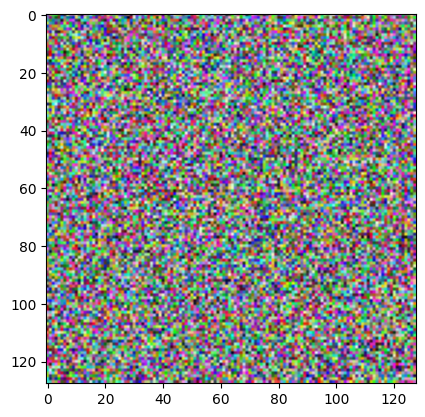

In [ ]:
generated_img = tf.random.uniform(shape = (128, 128, 3), minval =0, maxval = 1, dtype= tf.float32)
plt.imshow(generated_img)

In [ ]:
style_img = plt.imread('digital art style.PNG')[..., :3] # some image formats have 4 channels (rgba), we want only 3: rgb
content_img = plt.imread('bill gates.PNG')[..., :3]
#plt.imshow(style_img)
#plt.imshow(content_img)

# preprocess imgs
# normalize = false bc plt.imread=> pixel values in [0., 1.]

style_img = preprocess(style_img, size = vgg_input_shape, switch_bgr_channels= True, normalize= False)
content_img = preprocess(content_img, size = vgg_input_shape, switch_bgr_channels= True, normalize= False)
generated_img = preprocess(generated_img, size = vgg_input_shape, switch_bgr_channels= True, normalize= False)
#plt.imshow(style_img[0])

In [ ]:
print(generated_img.shape)
print(generated_img[0,20,20])

(1, 128, 128, 3)
tf.Tensor([0.9453604  0.9304545  0.94877803], shape=(3,), dtype=float32)


In [ ]:
a = deprocess(style_img, denormalize= False)
print(content_img.shape)
print(content_img[0, 10, 10])


(1, 128, 128, 3)
tf.Tensor([0.36617708 0.3730239  0.35563755], shape=(3,), dtype=float32)


(128, 128, 3)


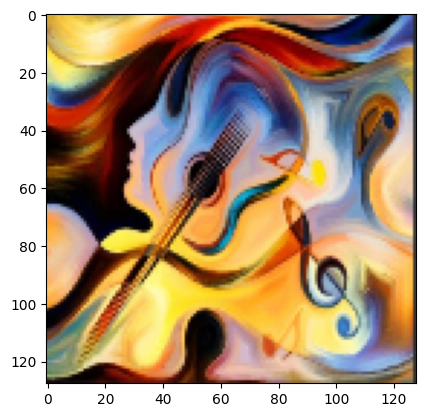

In [ ]:
plt.imshow(a)
print(a.shape)

In [ ]:
layer_names =     ['block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1']

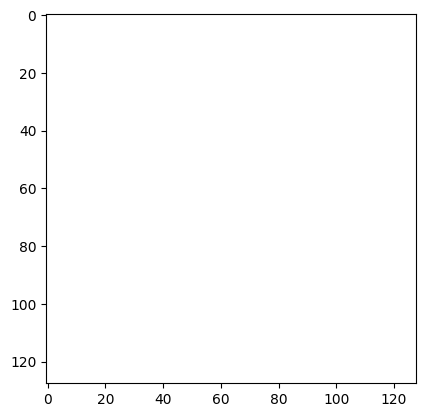

In [ ]:
generated_img = np.ones(shape = vgg_input_shape)
plt.imshow(generated_img)

generated_img = preprocess(generated_img, size = vgg_input_shape, switch_bgr_channels= True, normalize= False)


In [ ]:
# initializations
# create content and style models
content_model = create_content_model(model= model, layer_name = 'block5_conv4')
style_model = create_style_model(model = model, layer_names = layer_names)
#opt = tf.train.AdamOptimizer(learning_rate = 7.)
opt = tf.keras.optimizers.Adam(learning_rate= 10.)
generated_img = tf.Variable(generated_img)
for epoch in range(35):
    print(epoch, end = ' ')
    with tf.GradientTape() as tape:

        # keep watch on generated_img
        #tape.watch(generated_img)

        # calculate content  cost
        J_content = content_cost(content_model, content_img, generated_img)

        # calculate style cost

        style_activations = style_model(style_img)
        #print(style_activations)
        generated_activations = style_model(generated_img)
        #print(generated_activations)
        J_style = style_cost(style_activations = style_activations, 
                                generated_activations = generated_activations,
                                layer_weights = None)

        cost = total_cost(J_content, J_style , alpha = 60, beta = 40)
        if epoch % 5 == 0:
            print()
            print(cost)
    # compute gradients
    grads = tape.gradient(cost, generated_img)
    opt.apply_gradients([(grads, generated_img)])






0 
tf.Tensor(2974577700.0, shape=(), dtype=float32)
1 2 3 4 5 
tf.Tensor(1060396700000000.0, shape=(), dtype=float32)
6 7 8 9 10 
tf.Tensor(487211630000000.0, shape=(), dtype=float32)
11 12 13 14 15 
tf.Tensor(272612850000000.0, shape=(), dtype=float32)
16 17 18 19 20 
tf.Tensor(150230760000000.0, shape=(), dtype=float32)
21 22 23 24 25 
tf.Tensor(80455720000000.0, shape=(), dtype=float32)
26 27 28 29 30 
tf.Tensor(44452895000000.0, shape=(), dtype=float32)
31 32 33 34 

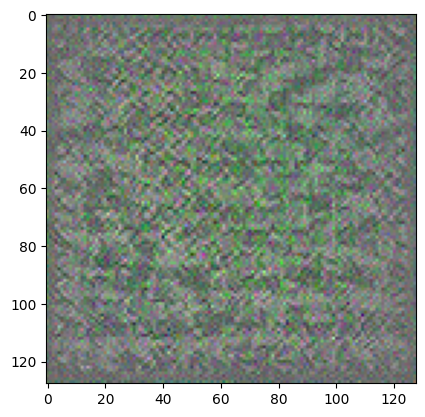

In [ ]:
plt.imshow(normalize_tensor(generated_img).numpy()[0])


tf.Tensor(77.81511, shape=(), dtype=float32)


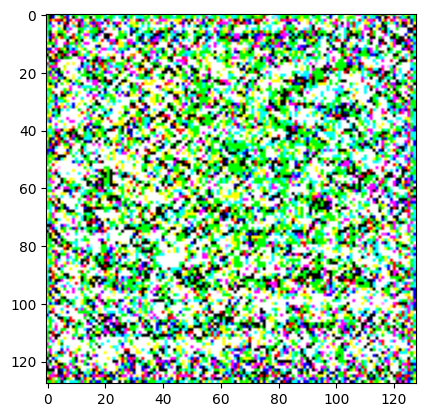

In [ ]:
#generated_img = deprocess(generated_img, switch_bgr_channels= True, denormalize = False)
plt.imshow(generated_img[0])
print(tf.reduce_max(generated_img))
#plt.imshow(generated_img * 25)